# Pràctica 2: Aprenentatge No Supervisat 
### Aprenentatge Automàtic i Mineria de Dades (AAMD) - GEI 2024-25
**Grup X - Nom1 Cognom1 - Nom2 Cognom2**

En aquesta pràctica aplicarem sis tècniques d'aprenentatge no supervisat sobre dos conjunts de dades: un conjunt sintètic i un de real. L'objectiu és comparar com cadascuna d'aquestes tècniques projecta o agrupa els patrons i explorar la seva estructura interna.

Abans de començar cal instalar algunes llibreries i modificar algunes existents per a que no hi hagi errors de compatibilitat, aixo es pot realitzar amb aquesta comanda, executeula a una consola i al cap d'una estona ja estara tot llest per funcionar:

pip install minisom

pip install torch


## Importació de llibreries

In [11]:
# 🔇 Amaguem warnings molestos de TensorFlow i Python
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0=tot, 1=info, 2=warnings, 3=només errors greus

# 📚 Imports habituals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🧠 Preprocessament i reducció de dimensionalitat
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 🤖 Clustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

# 🧭 Self-Organizing Maps
from minisom import MiniSom


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 🎨 Estil per a les gràfiques
sns.set(style="whitegrid")


## Lectura de les dades

In [12]:
# Carreguem els dos conjunts de dades
synthetic = pd.read_csv("A2-synthetic.txt")
real = pd.read_csv("A2-real.txt", sep=';')
synthetic.head(), real.head()

(         x1        x2        x3        x4  class
 0 -0.031676 -9.912054 -0.579436 -1.044239      1
 1  0.002526  6.172456  3.288339 -1.006427      5
 2  0.183123 -0.387841  6.236470 -1.691491      2
 3 -0.042262 -1.996272 -1.655302 -2.995311      1
 4 -0.062811 -0.417072  6.657475 -3.633134      4,
      BL    BD   FL    BM  S Location Class
 0  34.5  18.1  187  2900  1       L2    C1
 1  38.8  20.0  190  3950  0       L3    C1
 2  45.1  14.5  207  5050  1       L2    C2
 3  34.6  21.1  198  4400  0       L1    C1
 4  40.6  19.0  199  4000  0       L1    C1)

## Pre-processament de les dades

In [13]:
# Separació de característiques i etiquetes, i normalització
X_syn = synthetic.drop(columns=['class'])
y_syn = synthetic['class']
X_real = real.drop(columns=['Class', 'Location'])
y_real = real['Class']
scaler = StandardScaler()
X_syn_scaled = scaler.fit_transform(X_syn)
X_real_scaled = scaler.fit_transform(X_real)

## PCA (Principal Component Analysis)

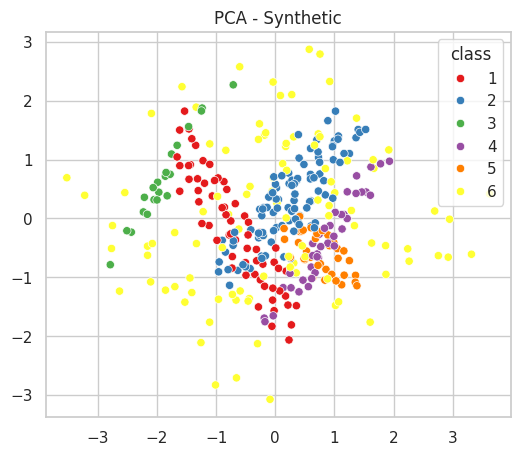

In [14]:
pca = PCA(n_components=2)
X_syn_pca = pca.fit_transform(X_syn_scaled)
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_syn_pca[:,0], y=X_syn_pca[:,1], hue=y_syn, palette='Set1')
plt.title("PCA - Synthetic")
plt.show()

## t-SNE

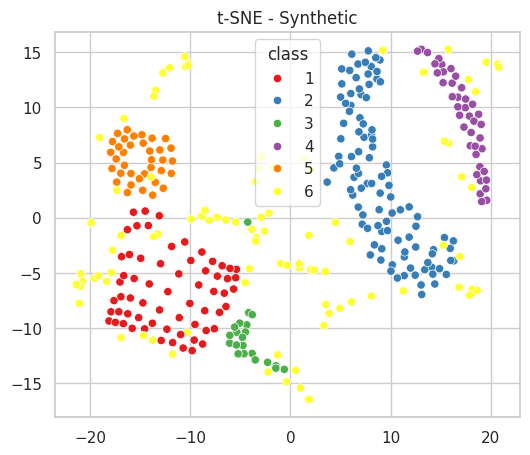

In [15]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_syn_tsne = tsne.fit_transform(X_syn_scaled)
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_syn_tsne[:,0], y=X_syn_tsne[:,1], hue=y_syn, palette='Set1')
plt.title("t-SNE - Synthetic")
plt.show()

## K-means Clustering

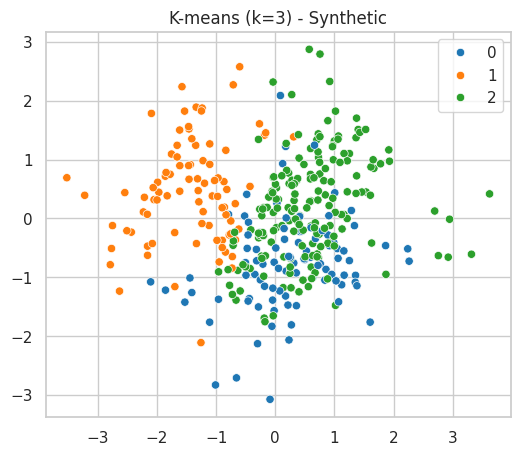

In [16]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_syn_scaled)
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_syn_pca[:,0], y=X_syn_pca[:,1], hue=labels, palette='tab10')
plt.title("K-means (k=3) - Synthetic")
plt.show()

## Clustering Jeràrquic (AHC)

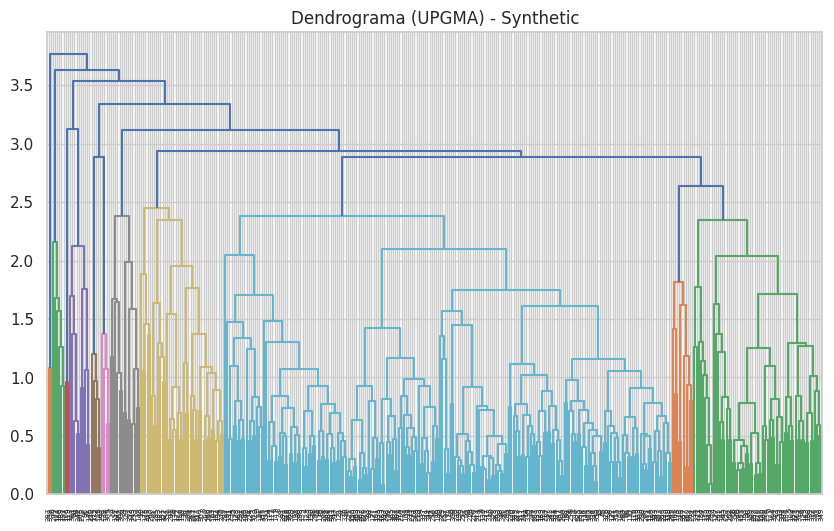

In [17]:
linkage_matrix = linkage(X_syn_scaled, method='average')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title("Dendrograma (UPGMA) - Synthetic")
plt.show()

## Autoencoder

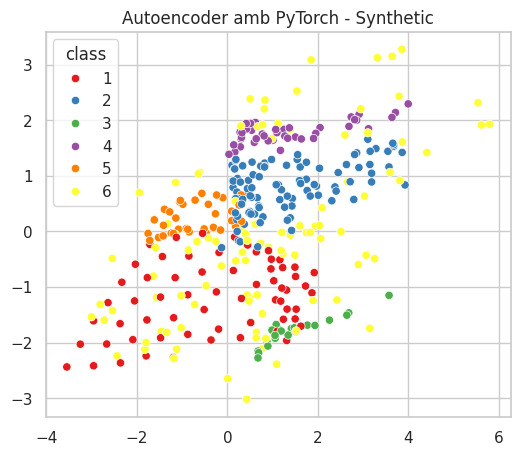

In [18]:


# Convertim les dades a tensors
X_tensor = torch.tensor(X_syn_scaled, dtype=torch.float32)

# Dataset i dataloader
dataset = TensorDataset(X_tensor, X_tensor)  # entrada = sortida (autoencoder)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Definim l'autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 2)  # bottleneck
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Inicialització i entrenament
model = Autoencoder(input_dim=X_syn_scaled.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenament
for epoch in range(100):
    for batch_x, _ in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_x)
        loss.backward()
        optimizer.step()

# Obtenir dades encodificades
with torch.no_grad():
    encoded_data = model.encoder(X_tensor).numpy()

# Visualització
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.scatterplot(x=encoded_data[:, 0], y=encoded_data[:, 1], hue=y_syn, palette='Set1')
plt.title("Autoencoder amb PyTorch - Synthetic")
plt.show()


## Self-Organizing Maps (SOM)

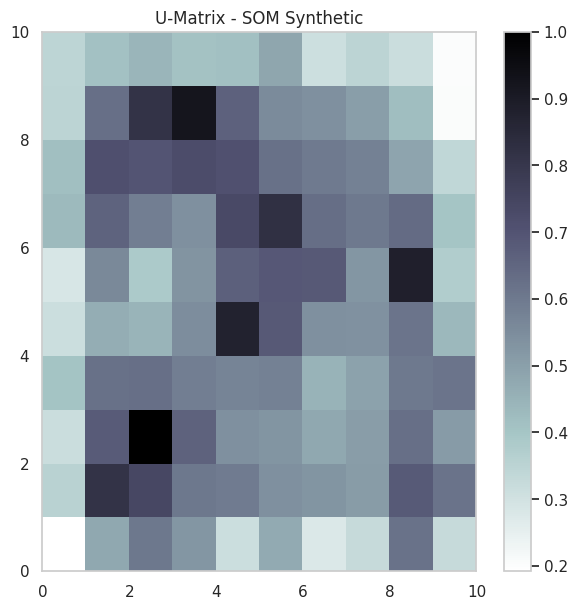

In [19]:
som = MiniSom(x=10, y=10, input_len=X_syn_scaled.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_syn_scaled)
som.train_random(X_syn_scaled, 1000)
plt.figure(figsize=(7,7))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.title("U-Matrix - SOM Synthetic")
plt.colorbar()
plt.show()